# Feature-engineering, Model-building and cost-benefit analysis

In [1414]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, plot_importance

import shap

In [1415]:
# Ensuring notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [1416]:
# Setting our seaborn style and palette
sns.set_style('darkgrid')
sns.set_palette('icefire')

## Feature-engineering

In [1417]:
# Read train.csv
train = pd.read_csv('../data/train.csv')
print(train.shape)
train.head(2)

(10506, 12)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [1418]:
# Convert column names to lowercase for standardisation
train.columns = train.columns.str.lower()

In [1419]:
# Are there any missing values in our train split?
train.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
dtype: int64

In [1420]:
# Let's look at the datatypes we have
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10506 non-null  object 
 1   address                 10506 non-null  object 
 2   species                 10506 non-null  object 
 3   block                   10506 non-null  int64  
 4   street                  10506 non-null  object 
 5   trap                    10506 non-null  object 
 6   addressnumberandstreet  10506 non-null  object 
 7   latitude                10506 non-null  float64
 8   longitude               10506 non-null  float64
 9   addressaccuracy         10506 non-null  int64  
 10  nummosquitos            10506 non-null  int64  
 11  wnvpresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [1421]:
# Taking a quick look at the dataset, we can drop some unnecessary columns
train.drop(columns=['address', 'block', 'street', 'addressaccuracy'], inplace=True)

In [1422]:
# Convert date column from object to datetime format
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

In [1423]:
# Let's break the date column down into years, months and weeks; We can then see if there is some seasonality
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week
train['year_month'] = train['date'].dt.strftime("%Y-%m")

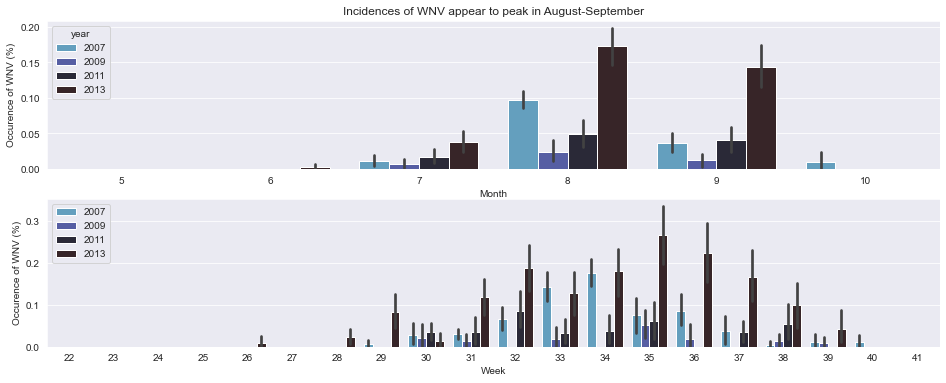

In [1424]:
# Visualise occurences of WNV throughout the years
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
sns.barplot(ax=axs[0], data=train, x='month', y='wnvpresent', hue='year')
axs[0].set_title("Incidences of WNV appear to peak in August-September")
axs[0].set_ylabel("Occurence of WNV (%)")
axs[0].set_xlabel("Month")

sns.barplot(ax=axs[1], data=train, x='week', y='wnvpresent', hue='year')
axs[1].set_ylabel("Occurence of WNV (%)")
axs[1].set_xlabel("Week")
plt.legend(loc="upper left")
plt.show()

**Our thoughts**: There appears to be some seasonality effects at play. Incidences of WNV appear to peak in August. But is this because more traps were set (i.e. more mosquitoes were caught) then?

In [1425]:
# Calculate number of traps set
count_traps = train.pivot_table(values=['nummosquitos'], index=['year_month'], columns="wnvpresent", aggfunc='count')

# Calculate total number of mosquitos caught
mosquitos_caught = train.pivot_table(values=['nummosquitos'], index=['year_month'], columns="wnvpresent", aggfunc='sum')

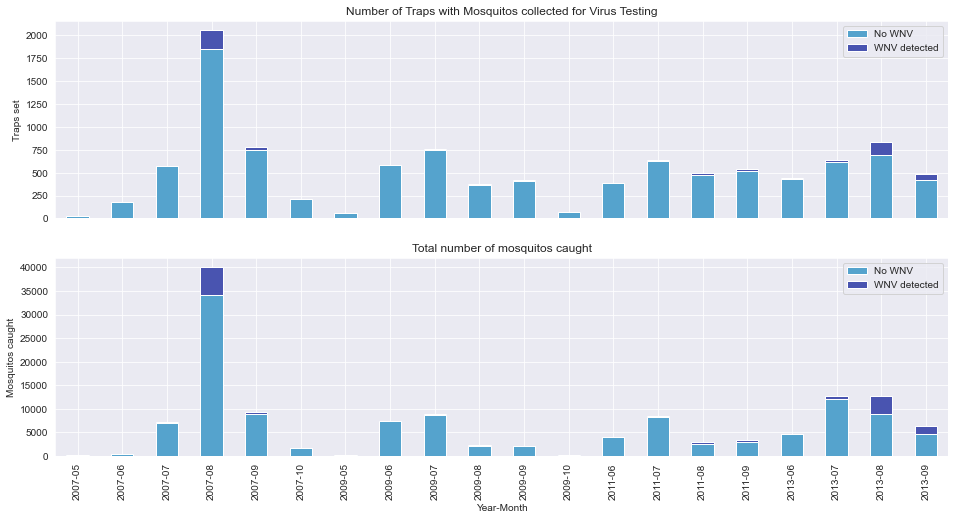

In [1426]:
# Visualising trends of traps and mosquitos caught over the past few years
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16,8))

count_traps.plot(ax=axs[0], kind="bar", stacked=True)
axs[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axs[0].set_xlabel("")
axs[0].set_ylabel("Traps set")
axs[0].legend(labels=["No WNV", "WNV detected"])

mosquitos_caught.plot(ax=axs[1], kind="bar", stacked=True)
axs[1].set_title("Total number of mosquitos caught")
axs[1].set_xlabel("Year-Month")
axs[1].set_ylabel("Mosquitos caught")
axs[1].legend(labels=["No WNV", "WNV detected"])

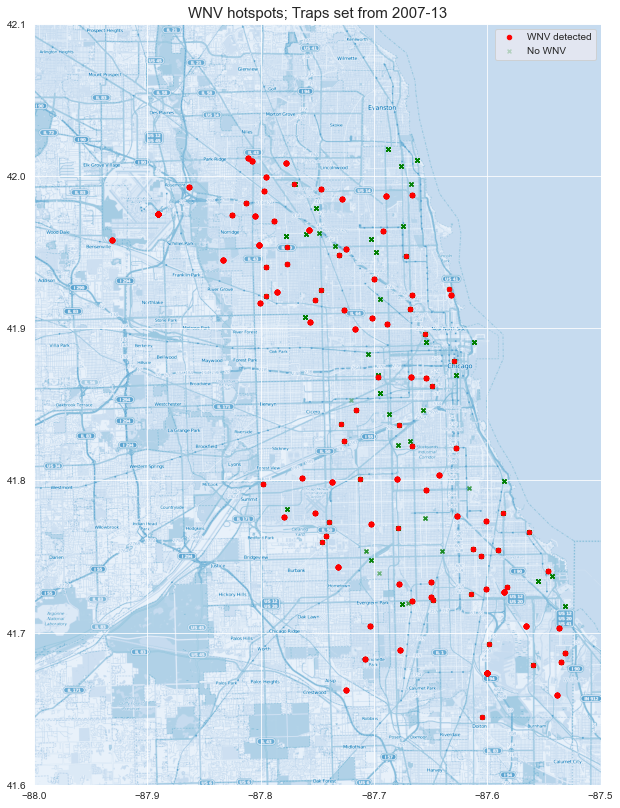

In [1427]:
# Let's visualise the locations of traps, as well as the presence of the WNV
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(14,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Blues_r'), 
           extent=lon_lat_box, 
           aspect=aspect)


wnv_traps = train.loc[train["wnvpresent"]==1]
ok_traps = train.loc[train["wnvpresent"]==0]

wnv_false = plt.scatter(ok_traps['longitude'], ok_traps['latitude'], c="green", marker='x', s=15, alpha=0.2)
wnv_true = plt.scatter(wnv_traps['longitude'], wnv_traps['latitude'], c="red", marker='o', s=20, alpha=1)

plt.title("WNV hotspots; Traps set from 2007-13", fontsize=15)
plt.legend((wnv_true, wnv_false), ("WNV detected", "No WNV"));

In [1428]:
# Does the species of mosquito matter?
species_wnv = train.pivot_table(values=['nummosquitos'], index='species', columns=['wnvpresent'], aggfunc='sum')

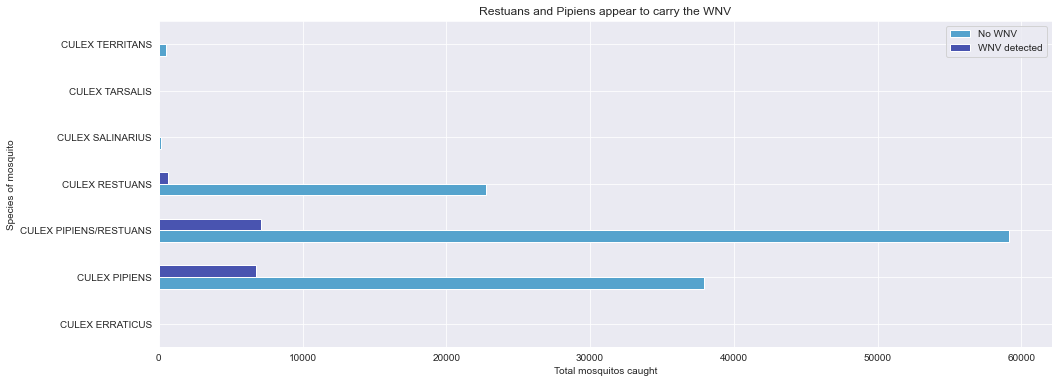

In [1429]:
# Visualising the incidence of WNV in different species
g = species_wnv.plot(kind="barh", stacked=False, figsize=(16,6))
g.set_title("Restuans and Pipiens appear to carry the WNV")
g.set_xlabel("Total mosquitos caught")
g.set_ylabel("Species of mosquito")
g.legend(labels=["No WNV", "WNV detected"])

In [1430]:
# Unqiue
train['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [1431]:
species_of_interest = ['RESTUANS', 'PIPIENS']

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
for i in species_of_interest:
    train[i] = 0
    for index, row in train.iterrows():
        if i in row["species"]:
            train[i][index] = 1 

In [1432]:
# Let's compute mean WNV incidence rate at different addresses
wnv_levels = train.pivot_table(index='addressnumberandstreet', values=['wnvpresent'])*100
wnv_levels_year = train.pivot_table(index='addressnumberandstreet', values=['wnvpresent'], columns=['year'])*100

In [1433]:
# Are there significant differences throughout the year
wnv_levels_year

wnvpresent            \
year                                                   2007      2009   
addressnumberandstreet                                                  
1000  E 67TH ST, Chicago, IL                       6.666667  0.000000   
1000  N CENTRAL PARK DR, Chicago, IL               0.000000  0.000000   
1000  S CALIFORNIA AVE, Chicago, IL                0.000000       NaN   
1000  S COTTAGE GROVE, Chicago, IL                 0.000000  2.941176   
1000  S STONY ISLAND AVE, Chicago, IL              6.896552  0.000000   
...                                                     ...       ...   
9100  W HIGGINS RD, Chicago, IL                         NaN  3.703704   
9300  S DR MARTIN LUTHER KING JR DR, Chicago, IL   4.761905       NaN   
9600  S HOYNE AVE, Chicago, IL                     0.000000       NaN   
9600  S LONGWOOD DR, Chicago, IL                        NaN       NaN   
9800  S AVENUE G, Chicago, IL                      0.000000       NaN   

                                                                       
year                                                  2011       2013  
addressnumberandstreet                                                 
1000  E 67TH ST, Chicago, IL                      3.448276   3.703704  
1000  N CENTRAL PARK DR, Chicago, IL              0.000000  17.777778  
1000  S CALIFORNIA AVE, Chicago, IL                    NaN        NaN  
1000  S COTTAGE GROVE, Chicago, IL                0.000000   3.125000  
1000  S STONY ISLAND AVE, Chicago, IL             0.000000   0.000000  
...                                                    ...        ...  
9100  W HIGGINS RD, Chicago, IL                   0.000000  12.195122  
9300  S DR MARTIN LUTHER KING JR DR, Chicago, IL       NaN        NaN  
9600  S HOYNE AVE, Chicago, IL                         NaN        NaN  
9600  S LONGWOOD DR, Chicago, IL                       NaN   0.000000  
9800  S AVENUE G, Chicago, IL                          NaN        NaN  

[138 rows x 4 columns]

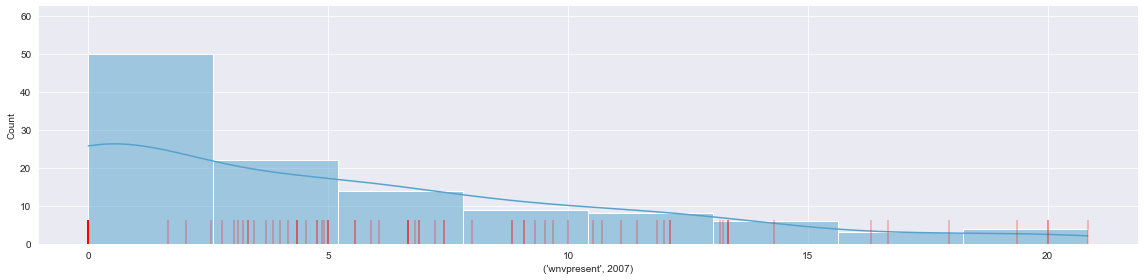

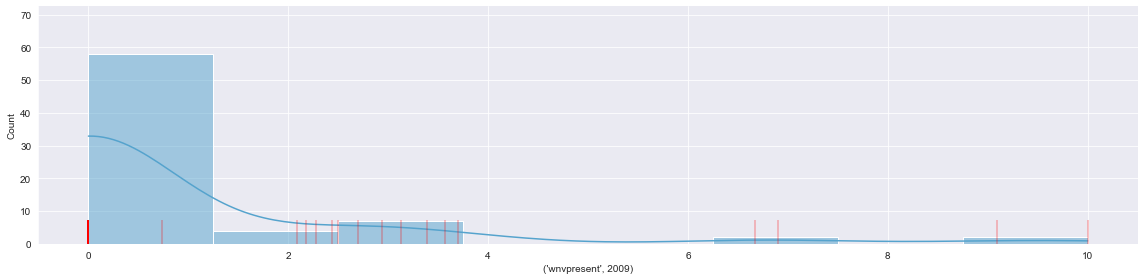

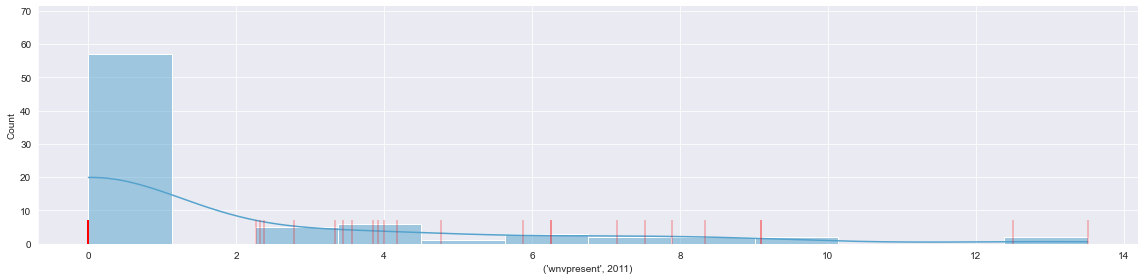

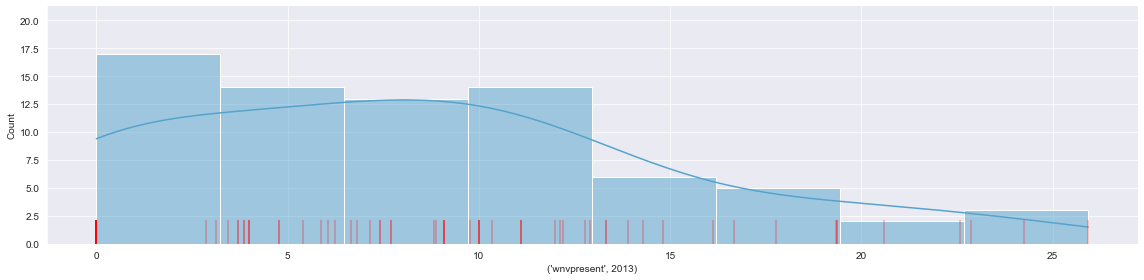

In [1434]:
# Let's visualise the distribution
sns.displot(data=wnv_levels_year[('wnvpresent', 2007)], aspect=4, kde=True, rug=True, 
            rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.5, "height":0.1}, height=4)

sns.displot(data=wnv_levels_year[('wnvpresent', 2009)], aspect=4, kde=True, rug=True, 
            rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.5, "height":0.1}, height=4)

sns.displot(data=wnv_levels_year[('wnvpresent', 2011)], aspect=4, kde=True, rug=True, 
            rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.5, "height":0.1}, height=4)

sns.displot(data=wnv_levels_year[('wnvpresent', 2013)], aspect=4, kde=True, rug=True, 
            rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.5, "height":0.1}, height=4)

In [1435]:
# We can take the average WNV incidence for each address
wnv_levels['risk_bucket'] = pd.cut(wnv_levels["wnvpresent"], 
                                   bins=[0, 2.5, 5, 10, 100], 
                                   right=False, labels=['very low', 'low', 'medium', 'high'], 
                                   ordered=True)
# Preview dataframe
wnv_levels.head()

,wnvpresent,risk_bucket
addressnumberandstreet,,
"1000 E 67TH ST, Chicago, IL",3.125000,low
"1000 N CENTRAL PARK DR, Chicago, IL",6.349206,medium
"1000 S CALIFORNIA AVE, Chicago, IL",0.000000,very low
"1000 S COTTAGE GROVE, Chicago, IL",1.785714,very low
"1000 S STONY ISLAND AVE, Chicago, IL",5.095541,medium


In [1436]:
# Write to csv
wnv_levels.to_csv('../data/wnv_levels.csv')

In [1437]:
# Let's chart it out
wnv_buckets = wnv_levels.reset_index().pivot_table(index='risk_bucket', values=['wnvpresent'], aggfunc='count')

In [1438]:
wnv_buckets.style.background_gradient(cmap="Reds_r")

,wnvpresent
risk_bucket,
very low,54
low,33
medium,36
high,15


In [1439]:
# Let's combine our wnv risk buckets with our original train data
train_combined = train.merge(wnv_levels[['risk_bucket']], how="left", on="addressnumberandstreet")

In [1440]:
# Let's now dummify the risk_bucket variables
train_dum = pd.get_dummies(train_combined, columns=['risk_bucket'], prefix="bucket")

### Combining with the ```weather``` dataset

In [1441]:
# We will need to create our own function to assign observations
def determine_station(lat, long):
    station1 = (41.995, -87.933) #Chicago O'Hare Tntl Airpot -> lat: 41.995 long: -87.933
    station2 = (41.786, -87.752) #Chicago Midway Tntl Airpot -> lat: 41.786 long: -87.752
    coordinates = (lat, long)
    return 1 if geodesic(coordinates, station1) < geodesic(coordinates, station2) else 2

In [1442]:
# Apply function to map our function
train_dum['station_ref'] = train_dum.apply(lambda i: determine_station(i['latitude'], i['longitude']), axis=1)

In [1443]:
train_dum.head()

,date,species,trap,addressnumberandstreet,latitude,longitude,nummosquitos,wnvpresent,year,month,week,year_month,RESTUANS,PIPIENS,bucket_very low,bucket_low,bucket_medium,bucket_high,station_ref
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0,2007,5,22,2007-05,1,1,0,0,1,0,1
1,2007-05-29,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,1,0,2007,5,22,2007-05,1,0,0,0,1,0,1
2,2007-05-29,CULEX RESTUANS,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,1,0,2007,5,22,2007-05,1,0,1,0,0,0,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,1,0,2007,5,22,2007-05,1,1,0,0,0,1,1
4,2007-05-29,CULEX RESTUANS,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,4,0,2007,5,22,2007-05,1,0,0,0,0,1,1


In [1444]:
# Let's see the breakdown of the data
train_dum['station_ref'].value_counts(normalize=True)

2    0.686084
1    0.313916
Name: station_ref, dtype: float64

In [1445]:
# Import tidied weather dataset
weather = pd.read_csv('../data/weather_tidied.csv')
print(weather.shape)
weather.head()

(2944, 13)


,station,date,tmax,tmin,tavg,dewpoint,preciptotal,stnpressure,sealevel,avgspeed,raining,misty,humidity
0,1,2007-05-01,83,50,67.0,51,0.0,29.10,29.82,9.2,0,0,56.410238
1,2,2007-05-01,84,52,68.0,51,0.0,29.18,29.82,9.6,0,0,54.497276
2,1,2007-05-02,59,42,51.0,42,0.0,29.38,30.09,13.4,0,1,71.176939
3,2,2007-05-02,60,43,52.0,42,0.0,29.44,30.08,13.4,0,1,68.594699
4,1,2007-05-03,66,46,56.0,40,0.0,29.39,30.12,11.9,0,0,54.848860


In [1446]:
# Convert date column to a datetime format
weather['date'] = pd.to_datetime(weather['date'], format="%Y-%m-%d")

In [1447]:
# Merge datasets
train_combined = train_dum.merge(weather, how="left", left_on=["station_ref", "date"], right_on=["station", "date"])

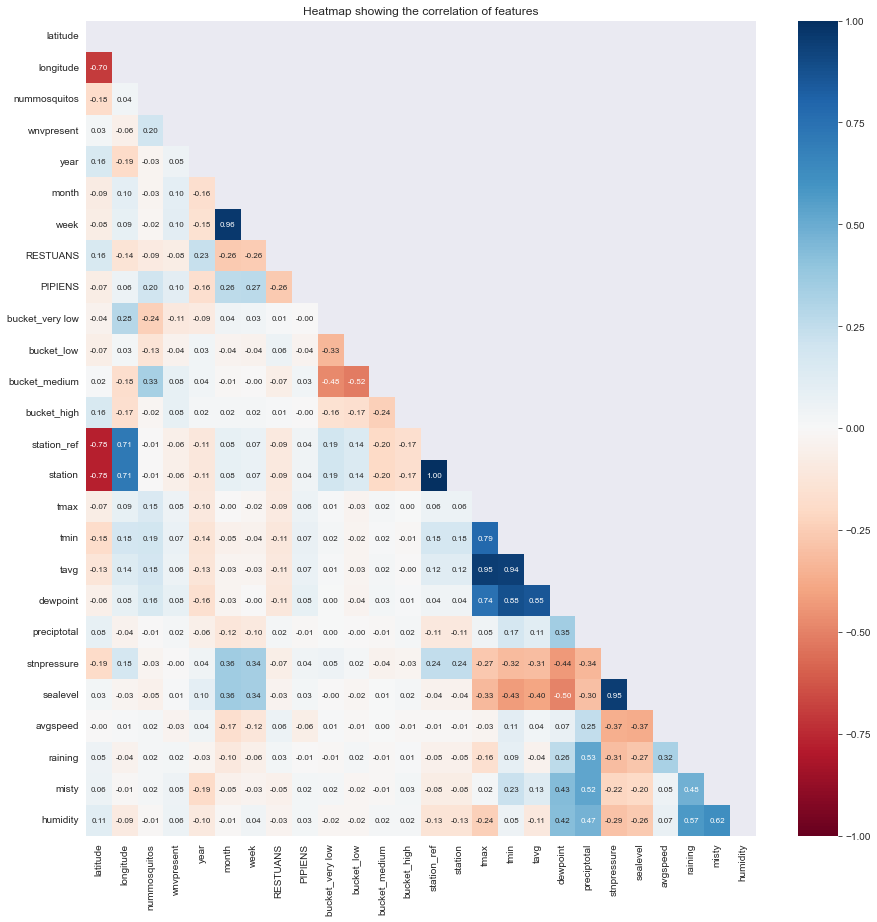

In [1448]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(train_combined.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,15))
plt.title("Heatmap showing the correlation of features")
sns.heatmap(train_combined.corr(), annot=True, mask= matrix, cmap="RdBu", 
           fmt=".2f", annot_kws={"size":8}, vmin=-1, vmax=1);

Zooming in on the correlations (with wnvpresent), there does not seem to be any significant correlation with the features we've selected. This could be because there may be time-lag in weather variables.

In [1449]:
def create_pivot(df):
    # Aggregating weather data by year and month
    weather['year_month'] = weather['date'].dt.strftime('%Y-%m')
    
    # Adding this to use as key for lag variables
    df['year_month_lag1'] = (df['date'] - pd.DateOffset(months=1)).dt.strftime('%Y-%m')

    # Creating a temporary pivot table to extract weather states by year month
    pivot = pd.DataFrame(pd.pivot_table(data=weather, index=['station','year_month'], 
                                        values=['tmin', 'tmax', 'tavg', 'dewpoint', 'preciptotal', 'sealevel', 
                                                'avgspeed', 'humidity'], aggfunc='mean').to_records())
    
    old_col = pivot.drop(columns='station').columns
    new_col = old_col + "_"
    pivot = pivot.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from pivot
    for i in new_col[1:]:
        print(i)
#         df = pivot[['station', 'year_month_', i]].merge(df, how='right', left_on=['station', 'year_month_'], 
#                                                         right_on=['station_ref', 'year_month']).rename(columns={i: i + 'lag0'}).drop(['station', 'year_month_'], axis='columns')
        
        df = pivot[['station', 'year_month_', i]].merge(df, how='right', left_on=['station', 'year_month_'], 
                                                        right_on=['station_ref', 'year_month_lag1']).rename(columns={i: i + 'lag1'}).drop(['station', 'year_month_'], axis='columns')
    
    return df

In [1450]:
train_combined.drop(columns=["station"], inplace=True)
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   species                 10506 non-null  object        
 2   trap                    10506 non-null  object        
 3   addressnumberandstreet  10506 non-null  object        
 4   latitude                10506 non-null  float64       
 5   longitude               10506 non-null  float64       
 6   nummosquitos            10506 non-null  int64         
 7   wnvpresent              10506 non-null  int64         
 8   year                    10506 non-null  int64         
 9   month                   10506 non-null  int64         
 10  week                    10506 non-null  UInt32        
 11  year_month              10506 non-null  object        
 12  RESTUANS                10506 non-null  int64 

In [1451]:
# apply the function above to effect the data transformation
train_transformed = create_pivot(train_combined)

avgspeed_
dewpoint_
humidity_
preciptotal_
sealevel_
tavg_
tmax_
tmin_


In [1452]:
train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   tmin_lag1               10422 non-null  float64       
 1   tmax_lag1               10422 non-null  float64       
 2   tavg_lag1               10422 non-null  float64       
 3   sealevel_lag1           10422 non-null  float64       
 4   preciptotal_lag1        10422 non-null  float64       
 5   humidity_lag1           10422 non-null  float64       
 6   dewpoint_lag1           10422 non-null  float64       
 7   avgspeed_lag1           10422 non-null  float64       
 8   date                    10506 non-null  datetime64[ns]
 9   species                 10506 non-null  object        
 10  trap                    10506 non-null  object        
 11  addressnumberandstreet  10506 non-null  object        
 12  latitude                10506 non-null  float6

In [1453]:
train_transformed.dropna(inplace=True)
train_transformed.drop(columns=['date', 'station_ref', 'year_month', 
                                'year_month_lag1', 'species', 
                                "addressnumberandstreet", "trap", "longitude", "latitude", "nummosquitos"], inplace=True)

In [1454]:
train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10422 entries, 25 to 10505
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tmin_lag1         10422 non-null  float64
 1   tmax_lag1         10422 non-null  float64
 2   tavg_lag1         10422 non-null  float64
 3   sealevel_lag1     10422 non-null  float64
 4   preciptotal_lag1  10422 non-null  float64
 5   humidity_lag1     10422 non-null  float64
 6   dewpoint_lag1     10422 non-null  float64
 7   avgspeed_lag1     10422 non-null  float64
 8   wnvpresent        10422 non-null  int64  
 9   year              10422 non-null  int64  
 10  month             10422 non-null  int64  
 11  week              10422 non-null  UInt32 
 12  RESTUANS          10422 non-null  int64  
 13  PIPIENS           10422 non-null  int64  
 14  bucket_very low   10422 non-null  uint8  
 15  bucket_low        10422 non-null  uint8  
 16  bucket_medium     10422 non-null  uint8

In [1455]:
# Defining X variables
X = train_transformed.drop(columns='wnvpresent')
y = train_transformed['wnvpresent']

In [1456]:
# Do a train-test split of 70-30 for train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, # Because this is an unbalanced dataset
                                                    random_state=42)

In [1457]:
# generates the full polynomial feature table
pf = PolynomialFeatures(include_bias=False, degree=2)
X_train_pf = pf.fit_transform(X_train)

# Adds appropriate feature names to all polynomial features
X_train_pf = pd.DataFrame(X_train_pf, columns=pf.get_feature_names(X_train.columns))
print(X_train_pf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Columns: 434 entries, tmin_lag1 to humidity^2
dtypes: float64(434)
memory usage: 24.2 MB
None


In [1458]:
# create function to run model with standard scaling, SMOTE sampling, 
# with an option to run grid search, model and print results

def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
    else:
        pipe.fit(X_train, y_train)
        

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    auc_scores = cross_val_score(pipe, X_train, y_train,  scoring='roc_auc', cv = 5)

    results['model'] = mod
    
    results['train_auc_cv'] = auc_scores.mean()
    
    results['f1'] = f1_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)        # % OF ACTUAL positives that are CORRECTLY predicted
    results['precision'] = precision_score(y_test, predictions)  # % OF positives that are CORRECTLY predicted

    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['auc_diff'] = results['train_auc'] - results['test_auc']

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)

    return pipe

In [1459]:
X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()

# create loop to run SMOTE sampling and compare the modelling outcomes with and without it
for k in ['No', 'SMOTE']:
    print('\nMethod Used: {}'.format(k + ' sampling'), "-" * 100)
        
    print('\nClass Balance BEFORE')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]))
  
    # instiantiate the models
    methods = {'SMOTE': SMOTE(random_state=42)}
    
    if k == 'SMOTE':
        mthd = methods[k]
        X_train, y_train = mthd.fit_resample(X_train, y_train)

    print('\nClass Balance AFTER')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]),'\n')
    
    
    # Instiantiate models
    models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
              'rf': RandomForestClassifier(random_state=42),
              'gb': GradientBoostingClassifier(random_state=42),
              'dt': DecisionTreeClassifier(random_state=42),
              'et': ExtraTreesClassifier(random_state=42),
              'ada': AdaBoostClassifier(random_state=42),
              'svc': SVC(random_state=42, probability=True),
              'xgb': XGBClassifier(random_state=42, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1)
            }

    # Instantiate lists to store results
    init_list = []
    gs_list = []

    for m in models:
        run_model(m)
    result_df = pd.DataFrame(init_list).sort_values(by=["f1"], ascending=False).reset_index(drop=True)
    display(result_df)

    X_train = X_train_copy
    y_train = y_train_copy


Method Used: No sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0    0.947087
1    0.052913
Name: wnvpresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0    0.947087
1    0.052913
Name: wnvpresent, dtype: float64

Number of rows: 7295 

[22:05:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:05:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:05:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:05:13] WARNING: C:/Users/Administrator/work

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,rf,0.777001,0.097778,0.066667,0.183333,0.945905,0.777949,0.167956
1,xgb,0.841379,0.094787,0.060606,0.217391,0.942306,0.827133,0.115173
2,et,0.751889,0.086124,0.054545,0.204545,0.946941,0.743382,0.203559
3,dt,0.746936,0.085714,0.054545,0.200000,0.946941,0.743192,0.203750
4,gb,0.862009,0.063830,0.036364,0.260870,0.904936,0.840997,0.063939
5,lr,0.833448,0.000000,0.000000,0.000000,0.842064,0.795831,0.046233
6,ada,0.856591,0.000000,0.000000,0.000000,0.885419,0.833291,0.052128
7,svc,0.768140,0.000000,0.000000,0.000000,0.873841,0.756353,0.117488



Method Used: SMOTE sampling ----------------------------------------------------------------------------------------------------

Class Balance BEFORE


0.0    0.947087
1.0    0.052913
Name: wnvpresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: wnvpresent, dtype: float64

Number of rows: 13818 

[22:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:53] WARNING: C:/Users/Administrator/wor

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,xgb,0.985368,0.305618,0.412121,0.242857,0.988960,0.830284,0.158676
1,gb,0.974843,0.300000,0.490909,0.216000,0.977282,0.836146,0.141137
2,ada,0.965260,0.292237,0.581818,0.195122,0.965878,0.836151,0.129727
3,et,0.976011,0.287703,0.375758,0.233083,0.989607,0.745062,0.244545
4,svc,0.958131,0.286567,0.581818,0.190099,0.964505,0.827143,0.137363
5,rf,0.980067,0.284404,0.375758,0.228782,0.988982,0.784045,0.204937
6,dt,0.975361,0.283721,0.369697,0.230189,0.989607,0.741404,0.248202
7,lr,0.857233,0.219761,0.781818,0.127849,0.859759,0.799649,0.060110


In [1460]:
print('\nClass Balance BEFORE')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]))

# instiantiate the SMOTE sampling method 
sm = SMOTE(random_state=42)  
X_train, y_train = sm.fit_resample(X_train, y_train)

print('\nClass Balance AFTER')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]),'\n')

# instantiate lists to store results
gs_list = []

# run the gridsearch using the function that was defined earlier
ada_best = run_model('ada', 
          mod_params={
              'ada__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
              'ada__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'ada__algorithm' :['SAMME', 'SAMME.R']
          },
          grid_search=True)
    
X_train = X_train_copy
y_train = y_train_copy


Class Balance BEFORE


0.0    0.947087
1.0    0.052913
Name: wnvpresent, dtype: float64

Number of rows: 7295

Class Balance AFTER


0.0    0.5
1.0    0.5
Name: wnvpresent, dtype: float64

Number of rows: 13818 

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
### BEST PARAMS ###


{'ada__algorithm': 'SAMME.R',
 'ada__learning_rate': 1,
 'ada__n_estimators': 200}

In [1461]:
ada_result_df = pd.DataFrame(gs_list).reset_index(drop=True)
display(ada_result_df)

,model,train_auc_cv,f1,recall,precision,train_auc,test_auc,auc_diff
0,ada,0.975128,0.286219,0.490909,0.201995,0.976875,0.837936,0.138939


In [1462]:
# create a function to plot the confusion matrix

def plot_confusion_matrix(y_test, test_preds):
    cm = confusion_matrix(y_test, test_preds)
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

    TN, FP, FN, TP = cm.ravel()

    print("Precison: {:.3f} (TP / (TP + FP))".format(TP / (TP + FP)))
    print("Recall: {:.3f} (TP / (TP + FN))".format(TP / (TP + FN)))
    print("F1 Score: {:.3f} (2*TP / (2*TP + FN + FP))".format(2*TP / (2*TP + FN + FP)), '\n')

    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=np.array(modified_cm),
                fmt="",
                annot_kws={"size": 10},
                linewidths=.5,
                square = True,
                cmap = 'Blues',
                xticklabels = ['Virus Absent', 'Virus Present'],
                yticklabels = ['Virus Absent', 'Virus Present'],
                )

    plt.ylabel('Actual', fontsize = 10);
    plt.xlabel('Predicted', fontsize = 10);
    plt.title('Confusion Matrix of Predictions', 
          fontweight='bold', fontsize=10);
    plt.tick_params(labelsize= 8)

In [1463]:
# show the best parameters for AdaBoosting
ada_best.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('ada',
                 AdaBoostClassifier(learning_rate=1, n_estimators=200,
                                    random_state=42))])

In [1464]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of WNV)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(ada_best.best_estimator_.named_steps["ada"].feature_importances_),
                            columns=['Importances']) 
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
df = pd.concat([features, coefficients], axis='columns').sort_values('Importances', ascending=False)
df

,Features,Importances
11,RESTUANS,0.170
12,PIPIENS,0.085
15,bucket_medium,0.085
16,bucket_high,0.070
10,week,0.055
24,avgspeed,0.050
19,tavg,0.045
17,tmax,0.040
13,bucket_very low,0.040
27,humidity,0.035


Precison: 0.202 (TP / (TP + FP))
Recall: 0.491 (TP / (TP + FN))
F1 Score: 0.286 (2*TP / (2*TP + FN + FP)) 



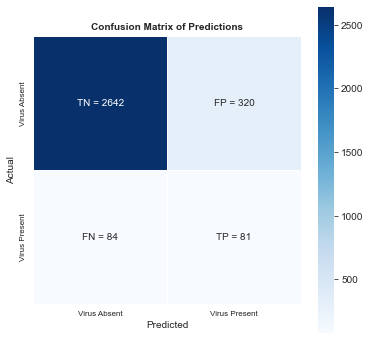

In [1465]:
# plot confusion matrix
plot_confusion_matrix(y_test, ada_best.best_estimator_.predict(X_test))

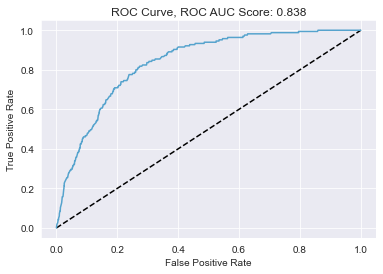

In [1466]:
y_pred_prob = ada_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_prob).round(3)))
plt.show()

#### XGBoost

In [1467]:
# Creating a pipeline model for StandardScaler, SMOTE and XGBoost
xgb_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('xgb', XGBClassifier(random_state=42, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1))
    ])
# Parameters
xgb_params = {  'xgb__learning_rate': [0.12],
                'xgb__max_depth': [50],
                'xgb__min_child_weight': [25],
                'xgb__gamma': [0.6],
                'xgb__subsample': [1],
                'xgb__scale_pos_weight': [75],
                'xgb__n_estimators': [42]}

In [1468]:
xgb_best = run_model('xgb', 
          xgb_params,
          grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[22:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[22:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[22:09:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' wa

{'xgb__gamma': 0.6,
 'xgb__learning_rate': 0.12,
 'xgb__max_depth': 50,
 'xgb__min_child_weight': 25,
 'xgb__n_estimators': 42,
 'xgb__scale_pos_weight': 75,
 'xgb__subsample': 1}

In [1469]:
xgb_best.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0.6, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.12,
                               max_delta_step=0, max_depth=50,
                               min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=42,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=75, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=1))])

In [1470]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of WNV)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(xgb_best.best_estimator_.named_steps["xgb"].feature_importances_),
                            columns=['Importances']) 
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
df = pd.concat([features, coefficients], axis='columns').sort_values('Importances', ascending=False)
df

,Features,Importances
1,tmax_lag1,0.273017
6,dewpoint_lag1,0.164124
13,bucket_very low,0.114112
7,avgspeed_lag1,0.044852
12,PIPIENS,0.036814
2,tavg_lag1,0.032911
24,avgspeed,0.030369
5,humidity_lag1,0.025426
17,tmax,0.023208
10,week,0.022987


Precison: 0.126 (TP / (TP + FP))
Recall: 0.806 (TP / (TP + FN))
F1 Score: 0.217 (2*TP / (2*TP + FN + FP)) 



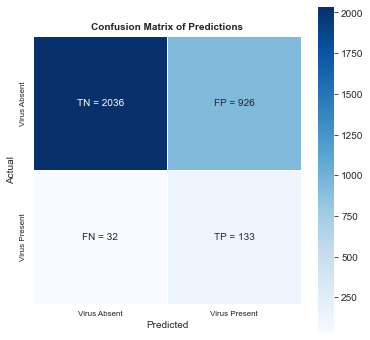

In [1471]:
# plot confusion matrix
plot_confusion_matrix(y_test, xgb_best.best_estimator_.predict(X_test))

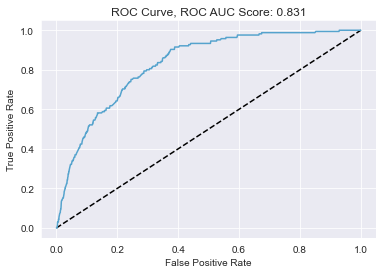

In [1472]:
y_pred_prob = xgb_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_prob).round(3)))
plt.show()

In [1473]:
train['wnvpresent'].value_counts()

0    9955
1     551
Name: wnvpresent, dtype: int64

## Tidying test-data

In [1474]:
# import cleaned datasets/ original Kaggle datasets 
test = pd.read_csv("../data/test.csv", parse_dates=[1])
weather = pd.read_csv("../data/weather_tidied.csv", parse_dates=[1])

In [1475]:
print(test.shape)
test.columns = test.columns.str.lower()
test.info()

(116293, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   address                 116293 non-null  object        
 3   species                 116293 non-null  object        
 4   block                   116293 non-null  int64         
 5   street                  116293 non-null  object        
 6   trap                    116293 non-null  object        
 7   addressnumberandstreet  116293 non-null  object        
 8   latitude                116293 non-null  float64       
 9   longitude               116293 non-null  float64       
 10  addressaccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [1476]:
def initial_clean(df):
    df.drop(columns=['address', 'block', 'street', 'addressaccuracy'], inplace=True)
    return df

In [1477]:
test_iter1 = initial_clean(test)
test_iter1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.2+ MB


In [1478]:
def date_feature_engineering(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['year_month'] = df['date'].dt.strftime("%Y-%m")

    return df

In [1479]:
test_iter2 = date_feature_engineering(test_iter1)
test_iter2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
 7   year                    116293 non-null  int64         
 8   month                   116293 non-null  int64         
 9   week                    116293 non-null  UInt32        
 10  year_month              116293 non-null  object        
dtypes: UInt32(1), datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 9.4+ MB


In [1480]:
# def dummify_species(df):
#     species_of_interest = ['RESTUANS', 'PIPIENS']
#     # create loop to create dummified variables to indicate presence of Pipiens & Restuans species
#     for i in species_of_interest:
#         df[i] = 0
#         for index, row in df.iterrows():
#             if i in row["species"]:
#                 df[i][index] = 1
    
#     return df

In [1481]:
test_iter3 = test_iter2
test_iter3['RESTUANS'] = test_iter2['species'].apply(lambda x: 1 if 'RESTUANS' in x else 0)
test_iter3['PIPIENS'] = test_iter3['species'].apply(lambda x: 1 if 'PIPIENS' in x else 0)

In [1482]:
test_iter3

,id,date,species,trap,addressnumberandstreet,latitude,longitude,year,month,week,year_month,RESTUANS,PIPIENS
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,2008,6,24,2008-06,1,1
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,2008,6,24,2008-06,1,0
2,3,2008-06-11,CULEX PIPIENS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,2008,6,24,2008-06,0,1
3,4,2008-06-11,CULEX SALINARIUS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,2008,6,24,2008-06,0,0
4,5,2008-06-11,CULEX TERRITANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,2008,6,24,2008-06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,2014,10,40,2014-10,0,0
116289,116290,2014-10-02,CULEX TERRITANS,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,2014,10,40,2014-10,0,0
116290,116291,2014-10-02,CULEX TARSALIS,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,2014,10,40,2014-10,0,0
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,"2100 N CANNON DR, Chicago, IL",41.925652,-87.633590,2014,10,40,2014-10,0,0


In [1483]:
# test_iter3 = dummify_species(test_iter2)
test_iter3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
 7   year                    116293 non-null  int64         
 8   month                   116293 non-null  int64         
 9   week                    116293 non-null  UInt32        
 10  year_month              116293 non-null  object        
 11  RESTUANS                116293 non-null  int64         
 12  PIPIENS                 116293

In [1484]:
# Read wnv risk buckets from folder
wnv_levels = pd.read_csv('../data/wnv_levels.csv')

In [1485]:
def dummify_risk_buckets(df, wnv_levels):
    merged_df = df.merge(wnv_levels[['addressnumberandstreet', 'risk_bucket']], how='left', on='addressnumberandstreet')
    merged_dum_df = pd.get_dummies(merged_df, columns=['risk_bucket'], prefix='bucket')
    
    return merged_dum_df

In [1486]:
test_iter4 = dummify_risk_buckets(test_iter3, wnv_levels)
test_iter4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
 7   year                    116293 non-null  int64         
 8   month                   116293 non-null  int64         
 9   week                    116293 non-null  UInt32        
 10  year_month              116293 non-null  object        
 11  RESTUANS                116293 non-null  int64         
 12  PIPIENS                 116293

In [1487]:
def determine_station(lat, long):
    station1 = (41.995, -87.933) #Chicago O'Hare Tntl Airpot -> lat: 41.995 long: -87.933
    station2 = (41.786, -87.752) #Chicago Midway Tntl Airpot -> lat: 41.786 long: -87.752
    coordinates = (lat, long)
    
    return 1 if geodesic(coordinates, station1) < geodesic(coordinates, station2) else 2

In [1488]:
%%time

# Apply function to map our function
test_iter4['station_ref'] = test_iter4.apply(lambda i: determine_station(i['latitude'], i['longitude']), axis=1)
test_iter4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
 7   year                    116293 non-null  int64         
 8   month                   116293 non-null  int64         
 9   week                    116293 non-null  UInt32        
 10  year_month              116293 non-null  object        
 11  RESTUANS                116293 non-null  int64         
 12  PIPIENS                 116293

In [1489]:
# Import tidied weather dataset
weather = pd.read_csv('../data/weather_tidied.csv', parse_dates=[1])
print(weather.shape)
weather.head()

(2944, 13)


,station,date,tmax,tmin,tavg,dewpoint,preciptotal,stnpressure,sealevel,avgspeed,raining,misty,humidity
0,1,2007-05-01,83,50,67.0,51,0.0,29.10,29.82,9.2,0,0,56.410238
1,2,2007-05-01,84,52,68.0,51,0.0,29.18,29.82,9.6,0,0,54.497276
2,1,2007-05-02,59,42,51.0,42,0.0,29.38,30.09,13.4,0,1,71.176939
3,2,2007-05-02,60,43,52.0,42,0.0,29.44,30.08,13.4,0,1,68.594699
4,1,2007-05-03,66,46,56.0,40,0.0,29.39,30.12,11.9,0,0,54.848860


In [1490]:
test_iter5 = test_iter4.merge(weather, how='left', left_on=['station_ref', 'date'], right_on=['station', 'date'])
test_iter5.drop(columns=["station"], inplace=True)
test_iter5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  object        
 3   trap                    116293 non-null  object        
 4   addressnumberandstreet  116293 non-null  object        
 5   latitude                116293 non-null  float64       
 6   longitude               116293 non-null  float64       
 7   year                    116293 non-null  int64         
 8   month                   116293 non-null  int64         
 9   week                    116293 non-null  UInt32        
 10  year_month              116293 non-null  object        
 11  RESTUANS                116293 non-null  int64         
 12  PIPIENS                 116293

In [1491]:
def create_pivot(df):
    # Aggregating weather data by year and month
    weather['year_month'] = weather['date'].dt.strftime('%Y-%m')
    
    # Adding this to use as key for lag variables
    df['year_month_lag1'] = (df['date'] - pd.DateOffset(months=1)).dt.strftime('%Y-%m')

    # Creating a temporary pivot table to extract weather states by year month
    pivot = pd.DataFrame(pd.pivot_table(data=weather, index=['station','year_month'], 
                                        values=['tmin', 'tmax', 'tavg', 'dewpoint', 'preciptotal', 'sealevel', 
                                                'avgspeed', 'humidity'], aggfunc='mean').to_records())
    
    old_col = pivot.drop(columns='station').columns
    new_col = old_col + "_"
    pivot = pivot.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from pivot
    for i in new_col[1:]:
        print(i)
#         df = pivot[['station', 'year_month_', i]].merge(df, how='right', left_on=['station', 'year_month_'], 
#                                                         right_on=['station_ref', 'year_month']).rename(columns={i: i + 'lag0'}).drop(['station', 'year_month_'], axis='columns')
        
        df = pivot[['station', 'year_month_', i]].merge(df, how='right', left_on=['station', 'year_month_'], 
                                                        right_on=['station_ref', 'year_month_lag1']).rename(columns={i: i + 'lag1'}).drop(['station', 'year_month_'], axis='columns')
    
    return df

In [1492]:
test_iter6 = create_pivot(test_iter5)
test_iter6.info()

avgspeed_
dewpoint_
humidity_
preciptotal_
sealevel_
tavg_
tmax_
tmin_
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   tmin_lag1               116293 non-null  float64       
 1   tmax_lag1               116293 non-null  float64       
 2   tavg_lag1               116293 non-null  float64       
 3   sealevel_lag1           116293 non-null  float64       
 4   preciptotal_lag1        116293 non-null  float64       
 5   humidity_lag1           116293 non-null  float64       
 6   dewpoint_lag1           116293 non-null  float64       
 7   avgspeed_lag1           116293 non-null  float64       
 8   id                      116293 non-null  int64         
 9   date                    116293 non-null  datetime64[ns]
 10  species                 116293 non-null  object        
 11  trap                

In [1493]:
test_iter6.drop(columns=['date', 'station_ref', 'year_month', 
                                'year_month_lag1', 'species', 
                                "addressnumberandstreet", "trap", "longitude", "latitude"], inplace=True)

In [1494]:
test_iter6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tmin_lag1         116293 non-null  float64
 1   tmax_lag1         116293 non-null  float64
 2   tavg_lag1         116293 non-null  float64
 3   sealevel_lag1     116293 non-null  float64
 4   preciptotal_lag1  116293 non-null  float64
 5   humidity_lag1     116293 non-null  float64
 6   dewpoint_lag1     116293 non-null  float64
 7   avgspeed_lag1     116293 non-null  float64
 8   id                116293 non-null  int64  
 9   year              116293 non-null  int64  
 10  month             116293 non-null  int64  
 11  week              116293 non-null  UInt32 
 12  RESTUANS          116293 non-null  int64  
 13  PIPIENS           116293 non-null  int64  
 14  bucket_high       116293 non-null  uint8  
 15  bucket_low        116293 non-null  uint8  
 16  bucket_medium     11

In [1495]:
def predict(df):
    df_id = df['id']

    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['wnvpresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba(df):
    df_coord = test[['latitude', 'longitude']]
    
    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = ada_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [1496]:
def predict_best(df, model_best):
    df_id = df['id']

    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['wnvpresent']) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba_best(df, model_best):
    df_coord = test[['latitude', 'longitude']]
    
    df_base = df.drop(columns=['id'])
    
    # generate predictions
    y_pred = model_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [1497]:
# generate predictions
pred = predict_best(test_iter6, xgb_best)

In [1498]:
pred.rename(columns={'id': 'Id', 'wnvpresent':'WnvPresent'}, inplace=True)

In [1499]:
pred.head()

,Id,WnvPresent
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [1500]:
pred = pred.set_index('Id')

In [1501]:
pred.to_csv('../kaggle/submission.csv')

In [1502]:
test.to_csv('../data/test_final.csv')

In [1503]:
pred.shape

(116293, 1)

#### SHAP for Model Interpretation

In [1504]:
from sklearn.pipeline import Pipeline

In [1505]:
shap.initjs()

In [1506]:
model = xgb_best.best_estimator_

In [1507]:
model

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0.6, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.12,
                               max_delta_step=0, max_depth=50,
                               min_child_weight=25, missing=nan,
                               monotone_constraints='()', n_estimators=42,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=75, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=1))])

In [1508]:
model[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.6, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.12, max_delta_step=0,
              max_depth=50, min_child_weight=25, missing=nan,
              monotone_constraints='()', n_estimators=42, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=75, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [1509]:
explainer = shap.TreeExplainer(model[1])

In [1510]:
shap_values = explainer(X_test)

#### Interpret Model Globally

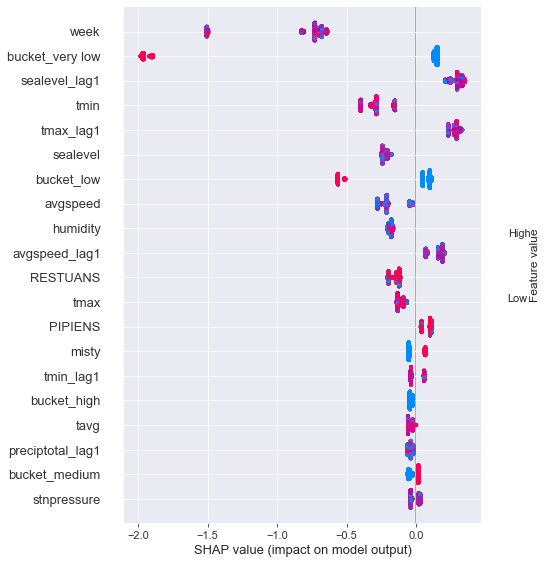

In [1511]:
shap.summary_plot(shap_values, X_test)

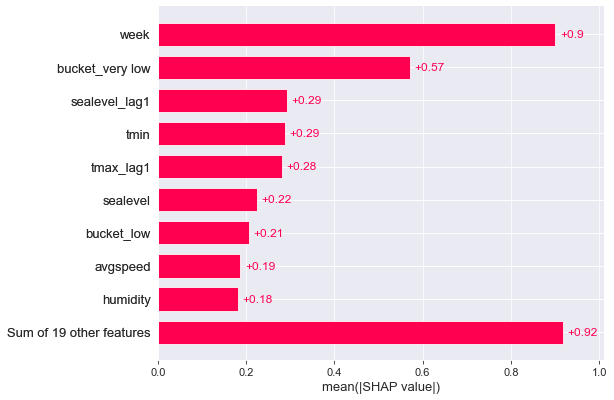

In [1512]:
shap.plots.bar(shap_values)

#### Interpret Model Locally - First 5 rows of X_test

In [1513]:
shap.plots.force(shap_values[0])

In [1514]:
shap.plots.force(shap_values[1])

In [1515]:
shap.plots.force(shap_values[2])

In [1516]:
shap.plots.force(shap_values[3])

In [1517]:
shap.plots.force(shap_values[4])